In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Esse notebook tem o objetivo de implementar o TSMOM do  Moskowitz. Portanto utilizarei uma parte do dataset, para facilitar a implementação. No dataset estão presentes apenas os preços de fechamento, e apenas de 1999 a 2019.

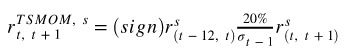
Em resumo a equação final do TSMOM do Moskowitz tem 3 partes: O cálculo do momento do ativo, A poderação do peso no portifolio, e a predição do retorno do ativo

Cálculo do Momento: Calcula-se o retorno do periodo desejado (no caso da image os ultimos 12 meses), e com o retorno e mãos retira-se o sinal, tomando assim uma posição de vendido ou comprado.

O peso no portifolio: Dependendo do periodo utiliza-se uma das seguintes ponderações: 20,40,60,120. E divide-se pelo desvio padrão da carteira
Um possivel melhora no algoritmo é utilizar o desvio padrão de cada ativo em suas respectivas ponderações

Predição do retorno: --

In [2]:
# Importação do csv previamente limpo
df = pd.read_csv ("close_clean_data.csv")

In [3]:
df.head()

,date,AN,BN,CC,CN,CT,DA,DX,EC,EN,...,ZW,ZZ,DT,HS,LX,ND,NK,SP,UB,AX
0,1999-06-21,42.81,143.90,2468.0,67.537,220.54,20.06,112.848,88.1480,3054.57,...,4614.72,163.364,75.10,11237.36,5618.6,2999.78,16474.0,1464.92,82.26,7704.9
1,1999-06-22,43.12,143.72,2421.0,67.537,222.69,20.20,113.002,88.1247,2984.70,...,4536.94,166.007,74.87,11138.79,5586.4,2931.16,16387.0,1453.39,82.11,7702.8
2,1999-06-23,43.39,142.89,2304.0,67.507,220.19,20.26,113.057,88.1060,3006.66,...,4558.54,165.846,74.47,11119.07,5536.9,2952.72,16262.0,1445.85,81.88,7601.4
3,1999-06-24,43.42,143.63,2227.0,67.497,222.81,20.29,112.419,88.0781,2952.09,...,4528.30,162.323,73.86,10914.04,5466.2,2899.13,16225.0,1435.62,81.59,7486.8
4,1999-06-25,43.64,143.52,2221.0,67.824,221.30,20.42,112.144,88.0781,2948.10,...,4562.87,162.963,74.17,10921.93,5478.0,2894.88,16229.0,1431.52,81.66,7511.3


In [4]:
# Calculo dos retornos percentuais e indexacao da data
returns_daily = df.drop('date', axis=1).pct_change().drop(0)
returns_daily.index = pd.to_datetime(df['date'], format='%Y-%m-%d').drop(0)

# Construção da matrix com os retornos mensais
returns_monthly = returns_daily.resample('BM').last().ffill()
returns_monthly = pd.DataFrame(returns_monthly)

In [5]:
from sklearn.linear_model import LinearRegression

# Calculo do retorno dos ultimos 12 meses
momentum_12 = returns_monthly.pct_change(6).dropna()

r_final = []
for month in range(3,161):
    
    # criando nova coluna order, para a regressao linear com datas
    dates = []
    for i in range(len(returns_monthly)):
        dates.append(i+1)

    returns_monthly['order']  = dates
    
    # variavel columns que tem o nome de todas os ativos para iteracao
    columns = returns_monthly.drop('order', axis=1).columns
    
    # target - rendimento passados; train - datas
    target = returns_monthly[:month].drop('order', axis=1)
    train = pd.DataFrame(dates[:month])

    # datas futura (t+1) para predicao 
    date_predict = pd.DataFrame([month+1])

    # instanciacao de modelo de predicao
    model = LinearRegression()

    # variaveis para amarmazenar as predicoes de cada coluna
    predict = []
    for i in columns:
        model.fit(train, target.loc[:,i])
        predict.append(model.predict(date_predict))
    
    # variavel position que guarda as posicoes obtidas pelo momento
    position = []
    for value in momentum_12.iloc[month]:
        # se momento for positivo - comprado
        if value > 0:
            position.append(-1)
        # se momento for negativo - vendido
        else:
            position.append(1)

    position = np.array(position)

    r_t1 = predict
    
    # peso de cada ativo no portifolio
    weights = target.std() / sum(target.std())

    r_final.append(1 + np.dot(position * weights, r_t1 ))

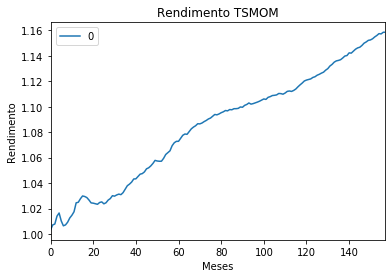

In [6]:
pd.DataFrame(r_final).cumprod().plot()
plt.xlabel('Meses')
plt.ylabel('Rendimento')
plt.title('Rendimento TSMOM')
plt.show()

In [7]:
pd.DataFrame(r_final).cumprod().iloc[-1]

0    1.158618
Name: 157, dtype: float64